# Data Preparation

Once data has been loaded and some initial cleaning is done, it is often necessary to perform several addition rounds of data preparation.  This can include scaling data, removing outliers, re-encoding variables, and imputing missing data.  We'll cover these aspects below.

## Scaling Data

Many machine learning algorithms, such as k-means clustering and support vector machines, use distance metrics like Euclidean distance to compare points in the feature space. Features with large numeric ranges can dominate the distance computation, thereby affecting the algorithm's performance. Similarly, optimization algorithms like gradient descent converge more quickly when features are on similar scales.

### 2. Working Example - Impact of Scaling on K-Means Clustering

Let's consider a simple synthetic dataset with two features `X1` and `X2`, where `X1` has values ranging between 0 and 10, but are separated into two groups along the axis. `X2` ranges from 0 to 1000, and so dominates the distance function. We'll cluster the data using k-means before and after scaling to see the difference.


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(0)
X1a = np.random.uniform(0, 4, 50)
X1b = np.random.uniform(6, 10, 50)
X1 = np.concatenate([X1a,X1b])
X2 = np.random.uniform(0, 1000, 100)
X = np.column_stack((X1, X2))

# Cluster without scaling
kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title('K-Means Clustering without Scaling')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cluster after scaling
kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(X_scaled)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis')
plt.title('K-Means Clustering with Scaling')
plt.xlabel('X1 (scaled)')
plt.ylabel('X2 (scaled)')
plt.show()


### 3. How to scale

Not all distributions are created equal!  It is important to examine your distributions before scaling parameters, or else your scaling efforts might not yield any improvements.

Two common types of distributions are normal and power-law (heavy-tailed) distributions.  These are easy to recognize by plotting histograms.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
n_samples = 1000

# Power-law (exponential) distribution
power_law_data = np.random.exponential(scale=10, size=n_samples)

# Scaled
scaled_power_law = np.log1p(power_law_data)

# Normal distribution
normal_data = np.random.normal(loc=50, scale=10, size=n_samples)
normal_data_2D = normal_data.reshape(-1, 1)

# Apply scaling
scaler = StandardScaler()
scaled_normal_data_2D = scaler.fit_transform(normal_data_2D)

# Convert back to 1D array
scaled_normal_data = scaled_normal_data_2D.ravel()


# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Plot power-law distribution
axes[0,0].hist(power_law_data, bins=30, color='blue', edgecolor='black')
axes[0,0].set_title("Power-law (Exponential) Distribution")
axes[0,0].set_xlabel("Value")
axes[0,0].set_ylabel("Frequency")

# Plot scaled power-law distribution
axes[1,0].hist(scaled_power_law, bins=30, color='blue', edgecolor='black')
axes[1,0].set_title("Scaled Exponential Distribution")
axes[1,0].set_xlabel("Value")
axes[1,0].set_ylabel("Frequency")

# Plot normal distribution
axes[0,1].hist(normal_data, bins=30, color='green', edgecolor='black')
axes[0,1].set_title("Normal Distribution")
axes[0,1].set_xlabel("Value")
axes[0,1].set_ylabel("Frequency")

# Plot scaled normal distribution
axes[1,1].hist(scaled_normal_data, bins=30, color='green', edgecolor='black')
axes[1,1].set_title("Normal Distribution")
axes[1,1].set_xlabel("Value")
axes[1,1].set_ylabel("Frequency")



plt.tight_layout()
plt.show()




- **Z-scaling**: Use it when the feature roughly follows a normal distribution or when you don't have information about the distribution. It transforms the data into a distribution with a mean of 0 and a standard deviation of 1.
  
- **Log-Scaling**: It is useful for features that follow a power-law distribution. In these cases, log-scaling can help equalize the ranges and variances across features.


### Exercise

In the following, I've created a sample dataset with an exponential feature and a normal feature. Try using the different scaling methods before running the classifier.  How do your results change:

1.  If you scale the exponential feature using a StandardScaler
2.  If you scale the exponential feature using a Log transform

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Create synthetic dataset
n_samples = 1000

# Feature 1: Power law (exponential) distribution
X1 = np.random.exponential(scale=5, size=n_samples)

# Feature 2: Normal distribution
X2 = np.random.normal(loc=50, scale=10, size=n_samples)

# Create labels: simple linear relation to X1 and X2
y = np.array([1 if x1 + 0.001 * x2 > 1 else 0 for x1, x2 in zip(X1, X2)])
flip_indices = np.random.choice(n_samples, size=int(0.1 * n_samples), replace=False)
y[flip_indices] = 1 - y[flip_indices]



# Combine features into single data array
X = np.column_stack((X1, X2))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression without scaling
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print(f"Logistic Regression without Scaling - Test Accuracy: {lr.score(X_test, y_test):.2f}")

# Plot original features
plt.figure(figsize=(12, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('Feature 1 (Power law)')
plt.ylabel('Feature 2 (Normal)')
plt.show()


# Missing Data

When dealing with missing data, understanding the mechanism behind the missingness can guide the selection of appropriate imputation methods. The three primary types of missing data are:

1. **Missing Completely At Random (MCAR)**: The missingness has no relationship with any other variable, observed or unobserved. It's random.

   - **Preferred Imputation Methods**: Mean, median, or mode imputation can be considered. More sophisticated techniques like k-Nearest Neighbors (k-NN) imputation can also be used.
   
   - **Notes**: Because the data is missing randomly, simpler methods often perform adequately.

   - **Example**: Suppose you're collecting data on the heights and weights of a class of students. If you lost some pages of your data collection notebook and that loss is unrelated to the actual data points themselves, then the missing data can be considered MCAR.



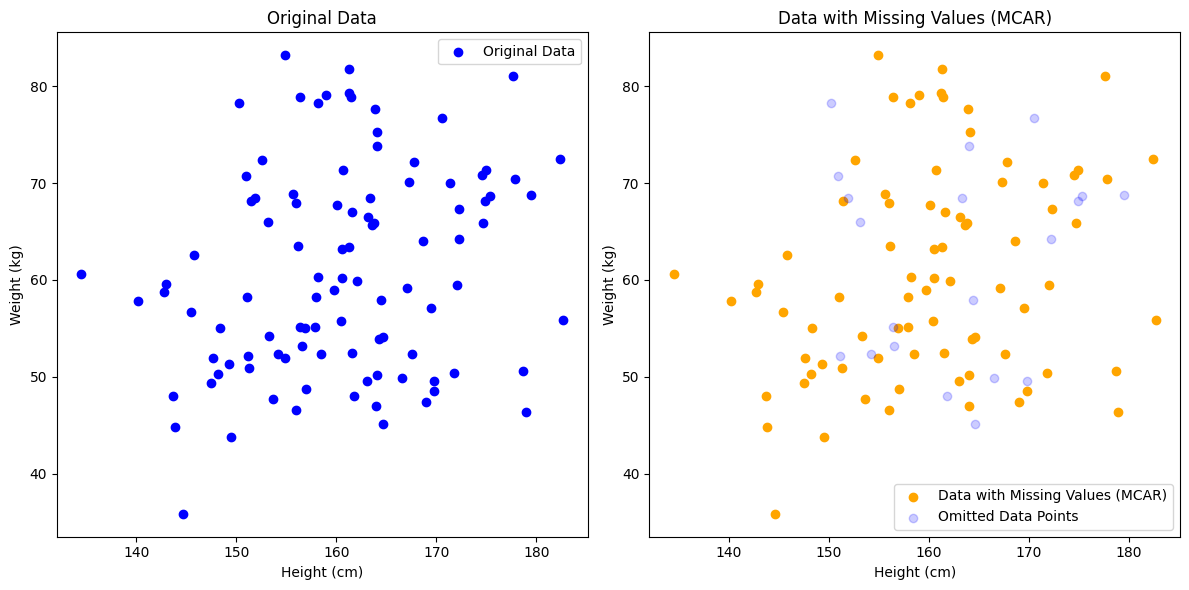

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Synthetic data for height and weight of students
np.random.seed(0)
n_students = 100
height = np.random.normal(160, 10, n_students)  # Average height is 160 cm with a standard deviation of 10

weight = 40 + height / 8 # simulate correlation between height and weight
noise = np.random.normal(0, 10, n_students)
weight+=noise   

# Randomly introduce missing data (MCAR)
missing_ratio = 0.2  # 20% of the data will be missing
missing_indices = np.random.choice(n_students, int(n_students * missing_ratio), replace=False)

# Make copies of original data for manipulation
height_missing = height.copy()
weight_missing = weight.copy()

# Introduce missing data
height_missing[missing_indices] = np.nan
weight_missing[missing_indices] = np.nan

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot of original data
axes[0].scatter(height, weight, c='blue', label='Original Data')
axes[0].set_title('Original Data')
axes[0].set_xlabel('Height (cm)')
axes[0].set_ylabel('Weight (kg)')
axes[0].legend()

# Scatter plot after introducing missing data
axes[1].scatter(height_missing, weight_missing, c='orange', label='Data with Missing Values (MCAR)')
axes[1].scatter(height[missing_indices], weight[missing_indices], c='blue', label='Omitted Data Points', alpha=0.2)
axes[1].set_title('Data with Missing Values (MCAR)')
axes[1].set_xlabel('Height (cm)')
axes[1].set_ylabel('Weight (kg)')
axes[1].legend()

plt.tight_layout()
plt.show()


2. **Missing At Random (MAR)**: The probability of missingness may be related to observed data but not the missing data.

   - **Preferred Imputation Methods**: Regression imputation, multiple imputation, and expectation-maximization are often used for MAR data.
   
   - **Notes**: These methods make use of other observed variables to predict and impute the missing variable.

   - **Example**: Suppose you're conducting a survey on income and age. Younger people might be less likely to disclose their income, but within the "young people" group, the chance of income being missing is random.


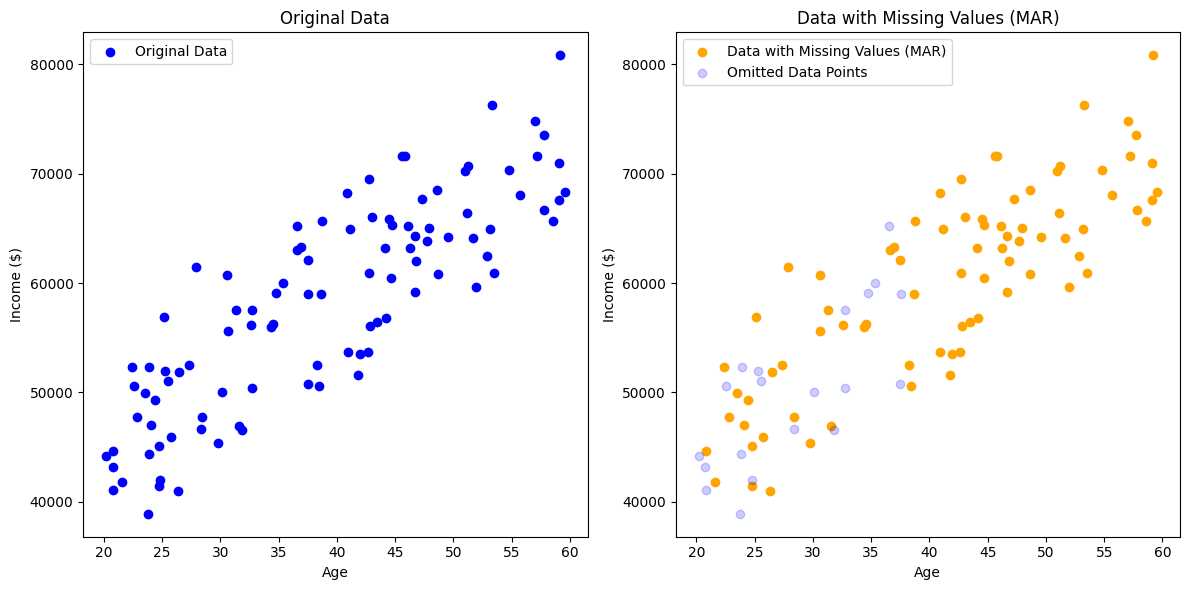

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# Generate synthetic data for income and age
np.random.seed(0)
n_people = 100
age = np.random.uniform(20, 60, n_people)  # Age ranges from 20 to 60
income = 30000 + age * 700  # Simulate a positive correlation between age and income

# Add some noise to the income
noise = np.random.normal(0, 5000, n_people)
income += noise

# Introduce missing data (MAR) for younger people
# Assume people aged less than 40 are less likely to disclose income
missing_ratio_young = 0.4  # 40% of young people's income will be missing
young_indices = np.where(age < 40)[0]
missing_indices_young = np.random.choice(young_indices, int(len(young_indices) * missing_ratio_young), replace=False)

# Make copies of original data for manipulation
income_missing = income.copy()

# Introduce missing data
income_missing[missing_indices_young] = np.nan

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot of original data
axes[0].scatter(age, income, c='blue', label='Original Data')
axes[0].set_title('Original Data')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Income ($)')
axes[0].legend()

# Scatter plot after introducing missing data
axes[1].scatter(age, income_missing, c='orange', label='Data with Missing Values (MAR)')
axes[1].scatter(age[missing_indices_young], income[missing_indices_young], c='blue', label='Omitted Data Points', alpha=0.2)
axes[1].set_title('Data with Missing Values (MAR)')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Income ($)')
axes[1].legend()

plt.tight_layout()
plt.show()




3. **Missing Not At Random (MNAR)**: The probability of missingness is related to the missing data itself or a combination of missing and observed data.

   - **Preferred Imputation Methods**: More complex methods such as multiple imputation using chained equations or advanced model-based methods can be used. In some cases, sensitivity analyses are performed.
  
   - **Notes**: Handling MNAR is particularly challenging because you have to model the missingness mechanism itself. This often involves making unverifiable assumptions.

   - **Example**: In a medical study, patients with severe symptoms are less likely to return for follow-up. Here, the missingness of the data (follow-up results) is directly related to the outcome (severity of symptoms).


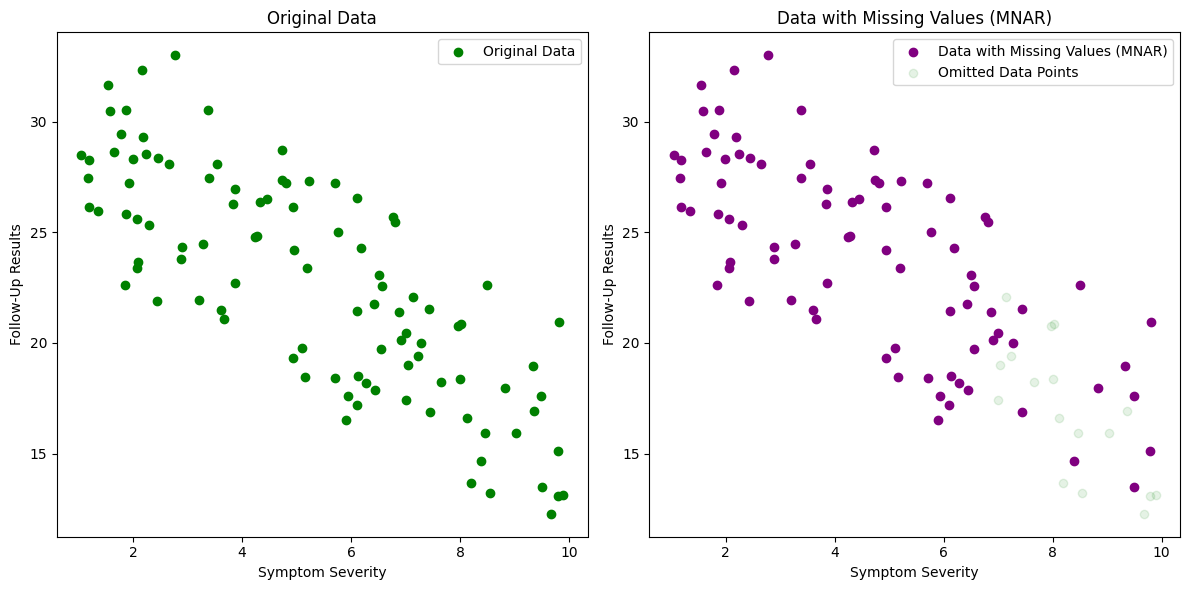

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Generate synthetic data for symptom severity and follow-up results
np.random.seed(0)
n_patients = 100
severity = np.random.uniform(1, 10, n_patients)  # Severity ranges from 1 to 10
follow_up = 30 - severity * 1.5  # Simulate a negative correlation between severity and follow-up results

# Add some noise to the follow-up results
noise = np.random.normal(0, 3, n_patients)
follow_up += noise

# Introduce missing data (MNAR) for patients with severe symptoms
# Assume patients with severity > 7 are less likely to have follow-up
missing_ratio_severe = 0.6  # 60% of severe patients' follow-up will be missing
severe_indices = np.where(severity > 7)[0]
missing_indices_severe = np.random.choice(severe_indices, int(len(severe_indices) * missing_ratio_severe), replace=False)

# Make copies of original data for manipulation
follow_up_missing = follow_up.copy()

# Introduce missing data
follow_up_missing[missing_indices_severe] = np.nan

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot of original data
axes[0].scatter(severity, follow_up, c='green', label='Original Data')
axes[0].set_title('Original Data')
axes[0].set_xlabel('Symptom Severity')
axes[0].set_ylabel('Follow-Up Results')
axes[0].legend()

# Scatter plot after introducing missing data
axes[1].scatter(severity, follow_up_missing, c='purple', label='Data with Missing Values (MNAR)')
axes[1].scatter(severity[missing_indices_severe], follow_up[missing_indices_severe], c='green', label='Omitted Data Points', alpha=0.1)
axes[1].set_title('Data with Missing Values (MNAR)')
axes[1].set_xlabel('Symptom Severity')
axes[1].set_ylabel('Follow-Up Results')
axes[1].legend()

plt.tight_layout()
plt.show()




### Imputation Methods:

1. **Simple Imputation**: Mean, median, or mode imputation is quick and easy but can reduce the variance of the imputed variables and underestimate errors.  Note that this method only uses information from the column in which data is missing.

2. **k-Nearest Neighbors (k-NN) Imputation**: This is a more advanced form of imputation that can be used for MCAR or MAR types of missingness. **Important** The KNN approach is based on the "K Nearest Neighbors" ML approach, which we'll talk about later.  However, it's important to know that it uses information from other columns in order to identify the most similar rows, and then derives the missing value from that.

3. **Multiple Imputation**: This technique is more robust and accounts for the uncertainty of missing values. It is often used for MAR and MNAR types of missingness.

4. **Model-based Imputation**: Methods like regression imputation or using machine learning models to predict missing values can be considered, especially when the data is MAR or MNAR.

5. **Sensitivity Analysis**: When you have MNAR data, it's often good to perform a sensitivity analysis to understand how your results might change under different assumptions about the missingness mechanism.

Would you like to include any of these points in your slides, or would you like to delve into one of these topics more deeply?

### Multiple Imputation by Chained Equations (MICE)

Multiple Imputation by Chained Equations (MICE), also known as Fully Conditional Specification (FCS), is a sophisticated method to handle missing data. It is especially useful when you have multiple variables with missing values and those missing values may be Missing At Random (MAR) or even Missing Not At Random (MNAR) to some extent.

#### How MICE Works:

1. **Initialization**: Start by filling in the missing values with a simple imputation method like mean imputation.
  
2. **Iterative Imputation**: 
    - For each variable with missing data:
        1. Set its missing values back to missing.
        2. Model this variable using the other variables.
        3. Use this model to impute the missing values.
    - Repeat this process for several iterations to make the imputations more robust.

3. **Multiple Datasets**: This process is repeated to create multiple datasets, and analyses are performed on each. 

4. **Pooling**: Results from these multiple analyses are pooled together to get final estimates.

<div style="text-align:center">

<img src="assets/MICE.png" width="500"/>

</div>



#### Key Features:

- **Chained Equations**: Each variable with missing data gets its own imputation model. This allows for different types of variables (e.g., continuous, ordinal, nominal).
  
- **Uncertainty**: By creating multiple datasets, MICE captures the uncertainty of missing values, thus providing a more accurate estimate of standard errors.

- **Flexibility**: You can specify different imputation models for different variables.

### Comparing Imputation Methods

It's informative to examine the impact of different imputation methods on distributions of data.  Note that this does not necessarily correlate with the performance of an ML algorithm!  

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# Create synthetic dataset with specific distributions
np.random.seed(0)
n = 200  # Number of samples
X1 = np.random.normal(5, 2, n)  # Normal distribution
X2 = np.random.exponential(1, n)  # Exponential distribution
X3 = np.random.uniform(0, 10, n)  # Uniform distribution

X_complete = np.column_stack((X1, X2, X3))

# Introduce some missing values
X_missing = np.copy(X_complete)
X_missing[np.random.randint(0, n, 20), 0] = np.nan
X_missing[np.random.randint(0, n, 20), 1] = np.nan
X_missing[np.random.randint(0, n, 20), 2] = np.nan

# Mean Imputation as an initial step
imp = SimpleImputer(strategy='mean')
X_initial_imputed = imp.fit_transform(X_missing)

# MICE Imputation
imp = IterativeImputer(max_iter=10, random_state=0)
X_mice_imputed = imp.fit_transform(X_missing)

# KNN Imputation
imp = KNNImputer()
X_knn_imputed = imp.fit_transform(X_missing)

# Random Forest Imputation
# Note - there is no built in method for RandomForest imputation, so we manually use a 
# RandomForestRegressor here to predict missing elements based on other elements.
X_rf_imputed = X_initial_imputed.copy()
for i in range(X_missing.shape[1]):
    missing_idx = np.isnan(X_missing[:, i])
    rf = RandomForestRegressor(n_estimators=100, random_state=0)
    rf.fit(X_initial_imputed[~missing_idx, :][:, np.arange(X_missing.shape[1]) != i], X_initial_imputed[~missing_idx, i])
    X_rf_imputed[missing_idx, i] = rf.predict(X_initial_imputed[missing_idx, :][:, np.arange(X_missing.shape[1]) != i])

# Create subplots
fig, axes = plt.subplots(6, 3, figsize=(20, 20))

# Titles
titles = ['Normal Feature', 'Exponential Feature', 'Uniform Feature']
imputation_methods = ['Original Complete', 'With Missing Values', 'Mean Imputed', 'MICE Imputed','Random Forest Imputed', 'KNN Imputed']

# Loop to plot histograms
for j, dataset in enumerate([X_complete, X_missing, X_initial_imputed, X_mean_imputed, X_rf_imputed, X_knn_imputed]):
    for i in range(3):
        axes[j, i].hist(dataset[:, i][~np.isnan(dataset[:, i])], bins=20, edgecolor='black')
        axes[j, i].set_title(f"{titles[i]} - {imputation_methods[j]}")
        axes[j, i].set_xlabel('Value')
        axes[j, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()




### Note: Making scikit learn and pandas work together

The interaction between pandas and scikit-learn can be a bit tricky due to the difference in data structures they expect. Let's take an example using `SimpleImputer` and a single column in a pandas DataFrame to highlight some of these issues.

#### What NOT to Do

One common mistake is to directly use pandas Series without reshaping it, resulting in an array with a single dimension. This can sometimes cause issues with scikit-learn estimators.


In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Create a DataFrame with missing values
df = pd.DataFrame({'A': [1, 2, None, 4, 5]})

# Initialize SimpleImputer
imputer = SimpleImputer(strategy='mean')

# This would NOT work as expected, raises an error or gives unwanted results
df['A'] = imputer.fit_transform(df['A'])



The issue arises because `df['A']` is a pandas Series, and passing it to `fit_transform` without reshaping might not work as expected.

#### What to Do

The correct approach is to ensure that you are working with a 2D array-like structure, which is what scikit-learn's `SimpleImputer` expects. One way to do this is to use double square brackets when slicing the DataFrame to keep it as a DataFrame with one column.

Here's how to do it correctly:


In [ ]:
# This would work as expected, returns a DataFrame
correct_df = df[['A']].copy()

# Impute missing values
correct_df_imputed = imputer.fit_transform(correct_df)

# Replace the original column with the imputed one
df['A'] = correct_df_imputed


Or, you could also reshape the Series to make it into a 2D array explicitly:


In [ ]:
# This would work as well, returns a 2D numpy array
correct_series = df['A'].values.reshape(-1, 1)

# Impute missing values
correct_series_imputed = imputer.fit_transform(correct_series)

# Replace the original column with the imputed one
df['A'] = correct_series_imputed



In both of these correct approaches, we're ensuring that the data passed to `SimpleImputer` is a 2D array-like structure, thus meeting scikit-learn's expectations.

## Exercise

The **Titanic dataset** contains the passenger list for all 768 passengers on the Titanic, as well as who survived.  Note that some features may or may not be meaningful for machine learning purposes.

The following columns are available in the original dataset:

1. **PassengerId**: An unique identifier for each passenger.
2. **Survived**: Whether the passenger survived or not. 1 for survived, 0 for deceased.
3. **Pclass**: The ticket class, indicating the socio-economic status of the passenger (1st = Upper, 2nd = Middle, 3rd = Lower).
4. **Name**: The full name of the passenger, sometimes including titles.
5. **Sex**: Gender of the passenger, usually 'male' or 'female'.
6. **Age**: Age of the passenger in years, although it's fractional if the age is less than one.
7. **SibSp**: The number of siblings or spouses aboard.
8. **Parch**: The number of parents or children aboard.
9. **Ticket**: The ticket number.
10. **Fare**: The amount of money paid for the ticket.
11. **Cabin**: The cabin number where the passenger stayed. This field contains many missing values.
12. **Embarked**: Port of embarkation, where C = Cherbourg, Q = Queenstown, S = Southampton.

Load the titanic data set from the seaborn library. Note that some columns are redundant, or may be labeled somewhat differently than in the original, and several are missing data.  Your task:

1. Load the dataset and identify the columns that have nulls.  Which columns do you think you should try to fill in?  Why?
2. For those that seem like they might matter for machine learning, apply the following methods to fill in nulls:
    - Fill forward, using 'ffill' (see Monday's lecture)
    - Use a "mean" with a SimpleImputer
    - Use a "most_frequent" with a simple imputer
    - Try to use a KNN imputer (see the important note above!).  It won't work!  What does the error say?
3. Compare histograms for your imputation methods.  Which would you pick?  Why?

In [ ]:
import seaborn as sns

titanic_data = sns.load_dataset('titanic')
titanic_data